**Quantitative Momentum Strategy Analysis**

Author: Luke Williams


This project analyzes two momentum-based strategies on a single asset:



1.   **Ride the Momentum:** Enters positions when momentum is positive and volatility is below a threshold.
2.   **Buy the Dip:** Enters positions when momentum is negative and volatility is low, attempting to profit from reversals.

Both strategies are tested across various momentum windows and volatility thresholds. Performance is evaluated using key metrics: Sharpe Ratio, Compound Annual Growth Rate (CAGR), and Maximum Drawdown. Results are compared to a Buy and Hold benchmark.

This analysis is **Level 1** of this project - a simplified but scalable framework. The core logic is a building block for more advanced systems. The goal here is clarity and flexibility, laying the groundwork for higher-level implementations in later versions.


In [1]:
#pip install yfinance pandas matplotlib numpy

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import datetime

#Functions

In [3]:
"""
For each strategy, it searches over a range of momentum windows and volatility thresholds,
computes Sharpe Ratio, CAGR, and Max Drawdown, and compares the best outcome to a Buy and Hold benchmark.

The following code is used as helper functions for computing returns, drawdowns, and adding momentum/volatility features.
"""
def drawdown(returns):
    cumulative = (1 + returns).cumprod()
    return ((cumulative / cumulative.cummax()) - 1) * 100

def compute_metrics(ret_series, rate=0):
    rate = float(rate) if isinstance(rate, str) else rate
    cum_ret = (1 + ret_series).cumprod()
    sharpe = ((ret_series.mean() - rate / 100 / 252) / ret_series.std() * np.sqrt(252)) if ret_series.std() != 0 else 0
    final_value = cum_ret.iloc[-1]
    num_years = (ret_series.index[-1] - ret_series.index[0]).days / 365.25
    cagr = final_value ** (1 / num_years) - 1
    max_drawdown = drawdown(ret_series).min()
    return round(sharpe, 2), round(cagr * 100, 1), round(max_drawdown, 1)

def format_percent_cols(df):
    df = df.copy()
    df['CAGR'] = df['CAGR'].map('{:.1f}%'.format)
    df['Max Draw'] = df['Max Draw'].map('{:.1f}%'.format)
    return df

def add_momentum_features(df, window):
    df = df.copy()
    df['Change'] = df['Close'].pct_change()
    df['Momentum'] = df['Close'].pct_change(window)
    df['sd'] = df['Change'].rolling(window).std()
    return df

def parse_date(input_str, default):
    if not input_str:
        return default
    try:
        return datetime.strptime(input_str, "%m/%d/%y").strftime("%Y-%m-%d")
    except ValueError:
        print("❌ Invalid date format. Use MM/DD/YY like 1/1/15.")
        exit()

In [4]:
def momentum_strategy(stock, sort='CAGR', rate=0):
    """
    Backtests two momentum-based strategies with volatility filters and compares them
    to a buy-and-hold benchmark.

    Strategies:
    - Ride Momentum: Go long when short-term momentum is positive and volatility is low.
    - Dip Buying: Go long when momentum is negative (a dip) but volatility is low.
    - Buy and Hold: Serves as baseline.

    Parameters:
    - stock (pd.DataFrame): DataFrame with 'Close' column of prices at the close that day.
    - sort (str): Metric to sort results by. Options: 'Sharpe', 'CAGR', etc.
    - rate (float): Risk-free rate to use in Sharpe ratio calculation.

    Returns:
    - str: Formatted summary table of the best-performing strategy variants.
    - pd.DataFrame: Best Ride Momentum result.
    - pd.DataFrame: Best Dip Buying result.
    - pd.DataFrame: Buy-and-Hold result.
    """

    # Make a working copy of the stock data
    stock_original = stock.copy()

    # Prepare storage for strategy results
    ride_results, dip_results, buy_and_hold_results = [], [], []

    # --- Buy and Hold ---
    stock_bh = stock_original.copy()
    stock_bh['Change'] = stock_bh['Close'].pct_change().dropna()

    # Compute metrics for buy and hold
    sharpe_bh, cagr_bh, max_draw_bh = compute_metrics(stock_bh['Change'], rate)
    buy_and_hold_results.append({
        'Window': 'N/A',
        'Vol': 'N/A',
        'Sharpe': sharpe_bh,
        'CAGR': cagr_bh,
        'Max Draw': max_draw_bh
    })

    # --- Grid Search over Momentum Window and Volatility Thresholds ---
    for momentum_window in range(2, 10):  # Try different lookback windows for momentum from 2 to 10 days
        stock_window = add_momentum_features(stock_original, momentum_window)

        for vol_threshold in np.arange(0.01, 0.10, 0.01):  # Sweep volatility thresholds
            # Ride strategy: Buy if momentum is up and volatility is low
            ride_signal = ((stock_window['Momentum'] > 0) & (stock_window['sd'] < vol_threshold)).shift(1).fillna(0)
            ride_ret = ride_signal * stock_window['Change']
            sharpe_r, cagr_r, max_draw_r = compute_metrics(ride_ret, rate)
            ride_results.append({
                'Window': momentum_window,
                'Vol': round(vol_threshold, 2),
                'Sharpe': sharpe_r,
                'CAGR': cagr_r,
                'Max Draw': max_draw_r
            })

            # Dip strategy: Buy when momentum is down (price has dipped) and volatility is low
            dip_signal = ((stock_window['Momentum'] < 0) & (stock_window['sd'] < vol_threshold)).shift(1).fillna(0)
            dip_ret = dip_signal * stock_window['Change']
            sharpe_d, cagr_d, max_draw_d = compute_metrics(dip_ret, rate)
            dip_results.append({
                'Window': momentum_window,
                'Vol': round(vol_threshold, 2),
                'Sharpe': sharpe_d,
                'CAGR': cagr_d,
                'Max Draw': max_draw_d
            })

    # Convert results to DataFrames
    ride_df = pd.DataFrame(ride_results)
    dip_df = pd.DataFrame(dip_results)

    # Find the best strategy in each category
    best_ride = ride_df.sort_values(by=sort, ascending=False).head(1)
    best_dip = dip_df.sort_values(by=sort, ascending=False).head(1)
    buy_and_hold = pd.DataFrame(buy_and_hold_results)

    # Format metrics
    best_ride_fmt = format_percent_cols(best_ride)
    best_dip_fmt = format_percent_cols(best_dip)
    buy_and_hold_fmt = format_percent_cols(buy_and_hold)

    # Create a summary of the best strategies
    output = [
        "**RIDE THE MOMENTUM STRATEGY**",
        tabulate(best_ride_fmt[['Window', 'Vol', 'Sharpe', 'CAGR', 'Max Draw']], headers='keys', tablefmt='pretty', showindex=False),
        "**DIP BUYING STRATEGY**",
        tabulate(best_dip_fmt[['Window', 'Vol', 'Sharpe', 'CAGR', 'Max Draw']], headers='keys', tablefmt='pretty', showindex=False),
        "**BUY AND HOLD STRATEGY**",
        tabulate(buy_and_hold_fmt[['Window', 'Vol', 'Sharpe', 'CAGR', 'Max Draw']], headers='keys', tablefmt='pretty', showindex=False)
    ]

    return "\n".join(output), best_ride, best_dip, buy_and_hold

In [5]:
def plot_drawdown(stock, dip=None, momentum=None):
    """
    Plots cumulative returns for Buy and Hold, Ride the Momentum, and Dip Buying strategies.

    Parameters:
    stock (pd.DataFrame): Buy and Hold strategy returns.
    momentum_ret (pd.Series): Cumulative returns for the Ride the Momentum strategy.
    dip_ret (pd.Series): Cumulative returns for the Dip Buying strategy.
    """
    stock = stock.copy()
    stock['Change'] = stock['Close'].pct_change()
    cumulative_bh = ((1 + stock['Change']).cumprod() - 1) * 100

    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    ax_drawdown, ax_cumulative = axes

    colors = ['black', '#ff7f0e', '#2ca02c']
    styles = ['--', ':', '-.']

    ax_drawdown.plot(drawdown(stock['Change']), color=colors[0], linestyle=styles[0], label='Buy & Hold')
    ax_drawdown.set_title('Drawdown Over Time')
    ax_drawdown.set_ylabel('Drawdown (%)')
    ax_drawdown.grid(True)
    ax_drawdown.legend()

    ax_cumulative.plot(cumulative_bh, color=colors[0], linestyle=styles[0], label='Buy & Hold')
    ax_cumulative.set_title('Cumulative Returns Over Time')
    ax_cumulative.set_ylabel('Cumulative Return (%)')
    ax_cumulative.set_xlabel('Year')
    ax_cumulative.grid(True)
    ax_cumulative.legend()

    if dip:
        window, vol = dip
        dip_df = add_momentum_features(stock, window)
        dip_signal = ((dip_df['Momentum'] < 0) & (dip_df['sd'] < vol)).shift(1).fillna(0)
        dip_ret = dip_signal * dip_df['Change']
        ax_drawdown.plot(drawdown(dip_ret), color=colors[1], linestyle=styles[1], label=f'Dip ({window}, {vol})')
        ax_cumulative.plot(((1 + dip_ret).cumprod() - 1) * 100, color=colors[1], linestyle=styles[1], label=f'Dip ({window}, {vol})')

    if momentum:
        window, vol = momentum
        mom_df = add_momentum_features(stock, window)
        momentum_signal = ((mom_df['Momentum'] > 0) & (mom_df['sd'] < vol)).shift(1).fillna(0)
        momentum_ret = momentum_signal * mom_df['Change']
        ax_drawdown.plot(drawdown(momentum_ret), color=colors[2], linestyle=styles[2], label=f'Momentum ({window}, {vol})')
        ax_cumulative.plot(((1 + momentum_ret).cumprod() - 1) * 100, color=colors[2], linestyle=styles[2], label=f'Momentum ({window}, {vol})')

    ax_drawdown.legend()
    ax_cumulative.legend()
    plt.tight_layout()
    plt.show()

In [8]:
"""
The `main` function serves as the entry point for the quantitative trading strategy.

It prompts the user to input the following parameters:
- **Ticker Symbol**: The stock or ETF symbol to analyze (e.g., SPY, NVDA).
- **Sorting Metric**: The metric used to sort the strategy's performance results (e.g., CAGR, Sharpe Ratio, Max Drawdown).
- **Start Date**: The start date for the analysis period (default is 1/1/15).
- **End Date**: The end date for the analysis period (default is 12/30/24).
- **Treasury Yield**: The yield on Treasury bonds, used to adjust the Sharpe ratio and performance metrics (default is 0%).

The function then:
1. Downloads historical price data from Yahoo Finance for the specified ticker and date range.
2. Prepares the data for analysis by adjusting columns for easier access.
3. Calls the `momentum_strategy` function to compute and evaluate the performance of the momentum and dip-buying strategies.
4. Displays the results of the best-performing strategies compared to the Buy-and-Hold benchmark.
5. Plots the cumulative returns of each strategy over time using `plot_drawdown`.

This function allows users to experiment with different tickers, time periods, and performance metrics to evaluate the effectiveness of the strategies.

"""

def main():
    ticker = input("Enter ticker symbol [SPY (default), NVDA, etc.]: ").upper() or "SPY"
    sort = input("Enter sorting metric [CAGR (default), Sharpe, Max Draw]: ") or "CAGR"
    start_input = input("Enter start date [MM/DD/YY, default: 1/1/15]: ")
    end_input = input("Enter end date [MM/DD/YY, default: 12/30/24]: ")
    treasury = input("Enter Treasury Yield (default: 0%): ") or "0"

    start_date = parse_date(start_input, "2015-01-01")
    end_date = parse_date(end_input, "2024-12-30")

    data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=False)
    data.columns = data.columns.get_level_values(0)

    print(f"\n{'=' * 30}")
    print(f"📈 {ticker} from {datetime.strptime(start_date, '%Y-%m-%d').strftime('%-m/%-d/%y')} to {datetime.strptime(end_date, '%Y-%m-%d').strftime('%-m/%-d/%y')}\n")

    output, best_ride, best_dip, bh = momentum_strategy(data, sort, treasury)
    print(output)
    plot_drawdown(data, dip=(int(best_dip['Window']), float(best_dip['Vol'])), momentum=(int(best_ride['Window']), float(best_ride['Vol'])))

#Open Up This code: then Run and Input stock and other variables to get Results (Run 'Functions' section beforehand)

Enter ticker symbol [SPY (default), NVDA, etc.]: 
Enter sorting metric [CAGR (default), Sharpe, Max Draw]: 
Enter start date [MM/DD/YY, default: 1/1/15]: 
Enter end date [MM/DD/YY, default: 12/30/24]: 
Enter Treasury Yield (default: 0%): 

📈 SPY from 1/1/15 to 12/30/24

**RIDE THE MOMENTUM STRATEGY**
+--------+------+--------+------+----------+
| Window | Vol  | Sharpe | CAGR | Max Draw |
+--------+------+--------+------+----------+
|   9    | 0.09 |  0.8   | 8.0% |  -14.5%  |
+--------+------+--------+------+----------+
**DIP BUYING STRATEGY**
+--------+------+--------+-------+----------+
| Window | Vol  | Sharpe | CAGR  | Max Draw |
+--------+------+--------+-------+----------+
|   5    | 0.06 |  0.8   | 10.1% |  -21.4%  |
+--------+------+--------+-------+----------+
**BUY AND HOLD STRATEGY**
+--------+-----+--------+-------+----------+
| Window | Vol | Sharpe | CAGR  | Max Draw |
+--------+-----+--------+-------+----------+
|  N/A   | N/A |  0.69  | 11.2% |  -34.1%  |
+--------+---

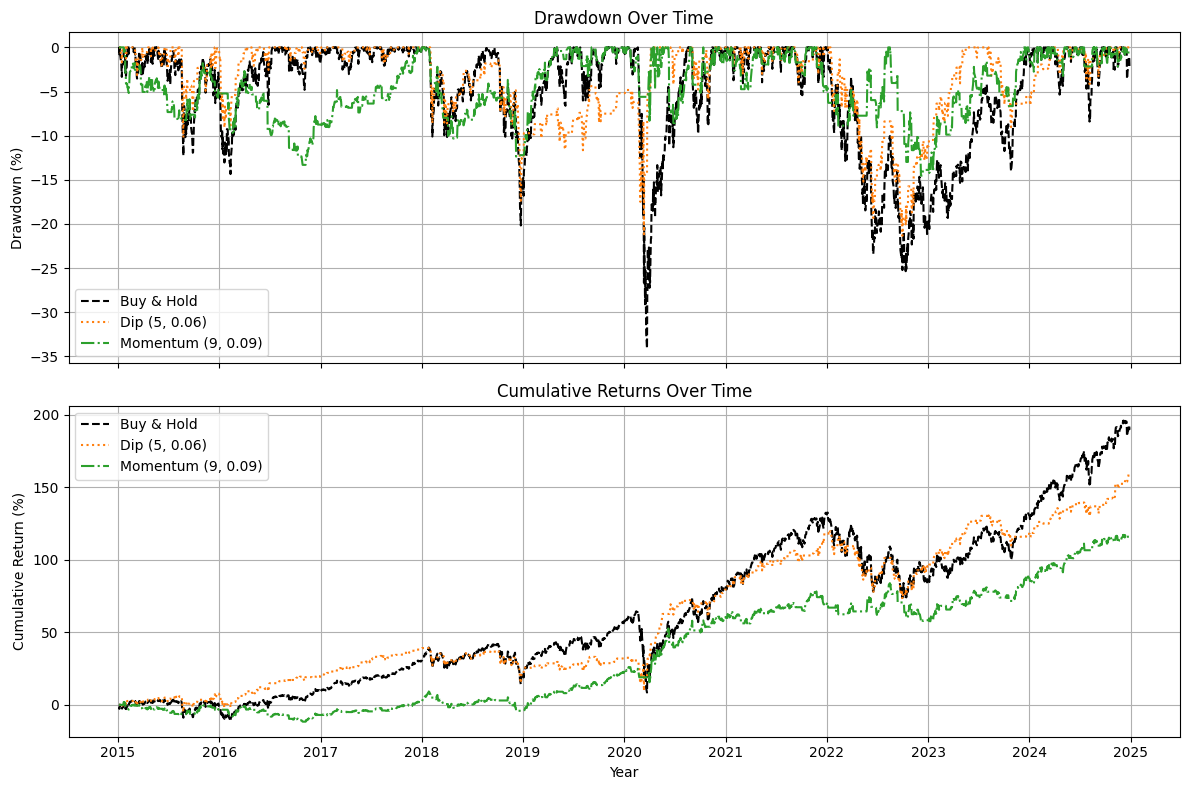

In [9]:
if __name__ == '__main__':
    main()